Peer-graded Assignment: Week 3: CNN Cancer Detection Kaggle Mini-Project

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, Image
import PIL
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import time
import concurrent.futures
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

## Brief description of the problem

The main task in this competition is to create an algorithm that can identify metastatic tissue in histopathologic scans of lymph node sections. More specifically, the algorithm should, with a high level of accuracy, to be able to classify 57 458 test images as either malignant or normal, where malignant implies that the image contains at least one pixel of tumor tissue in the center 32x32px of the picture. To assist in this task, Kaggle has provided a training dataset consisting of 220 025 images with known labels (malignant or normal). Both the training and test data originate from the PatchCamelyon (PCam) benchmark dataset. The only difference is that the original PCam dataset contains duplicate images due to its probabilistic sampling, while the version provided on Kaggle does not contain duplicates. For more information about the competition see https://www.kaggle.com/c/histopathologic-cancer-detection/overview.

### EDA

In [13]:
def display_images(image_names, title):
    """
    Displays five images side by side from the 'train' folder.

    :param image_names: List of image file names (without extension)
    :param title: String for title of display
    """
    # Check if there are exactly five images
    if len(image_names) != 5:
        raise ValueError("Please provide exactly five image names")

    # Path to training folder
    folder_path = 'train'

    # Setting up the plot
    plt.figure(figsize=(20, 10))  # Adjust the size as per your preference

    for i, image_name in enumerate(image_names, 1):
        # Construct the full path to the image
        img_path = os.path.join(folder_path, image_name + '.tif')
        img = plt.imread(img_path)
        plt.subplot(1, 5, i)
        plt.imshow(img)
        plt.axis('off')  # Turn off axis numbering

    # Add a title to the figure
    plt.suptitle(title, fontsize=25, y=0.95)

    # Manually adjust the spacing
    plt.subplots_adjust(top=1.38)  # You might need to tweak this value

    plt.show()


def get_first_image_shape(folder_path):
    # Get the first image file from the folder
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    first_image_file = image_files[0] if image_files else None

    if first_image_file:
        # Construct the full path to the first image
        img_path = os.path.join(folder_path, first_image_file)

        # Open the image
        with PIL.Image.open(img_path) as img:
            # Get image dimensions and number of color channels
            width, height = img.size
            num_channels = len(img.getbands())
            return (height, width, num_channels)
    else:
        return None

In [14]:
# The Number of images in the dataset
print(f"The Number of training images: {len(os.listdir('train')) : >10}")
print(f"The Number of test images: {len(os.listdir('test')) : >14}")

The Number of training images:     220025
The Number of test images:          57458


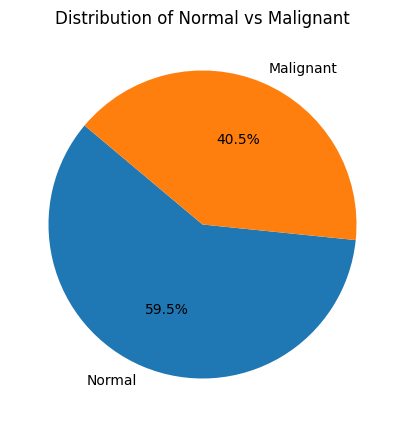

In [15]:
# Load the training and test data labels into a Pandas dataframe
df = pd.read_csv('train_labels.csv')
df_sample = pd.read_csv("sample_submission.csv")

# Count the occurrences of each category in the training set
category_count = df['label'].value_counts().rename({0: 'Normal', 1: 'Malignant'})

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(category_count, labels=category_count.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Normal vs Malignant')
plt.show()

In [16]:
print("Inspection:\n")

print("TRAINING DATA")
print(f"All training labels are valid (0 or 1):        {(df.label.unique().all() in [0, 1])}")
print(f"All training ids are unique (no dublicates):   {len(df.id.unique()) == 220025}")
print(f"There is the same number of ids as images:     {len(df.id.unique()) == 220025}")
print(f"Shape of training image is 96 x 96 x 3:        {get_first_image_shape('train') == (96, 96, 3)}")
print()

print("TESTING DATA")
print(f"All test ids are unique (no dublicates):       {len(df_sample.id.unique()) == 57458}")
print(f"There is the same number of ids as images:     {len(df_sample.id.unique()) == 57458}")
print(f"Shape of testing image is 96 x 96 x 3:         {get_first_image_shape('test') == (96, 96, 3)}")
print()

Inspection:

TRAINING DATA
All training labels are valid (0 or 1):        True
All training ids are unique (no dublicates):   True
There is the same number of ids as images:     True
Shape of training image is 96 x 96 x 3:        True

TESTING DATA
All test ids are unique (no dublicates):       True
There is the same number of ids as images:     True
Shape of testing image is 96 x 96 x 3:         True



In [17]:
malignant = df.loc[df['label']==1]['id'].values
normal    = df.loc[df['label']==0]['id'].values

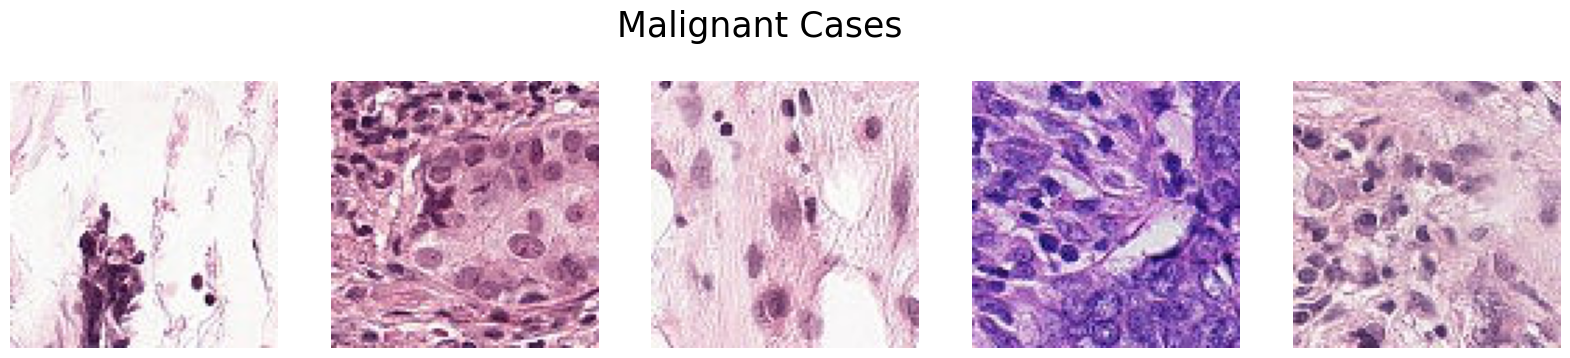

In [18]:
display_images(malignant[:5], 'Malignant Cases')

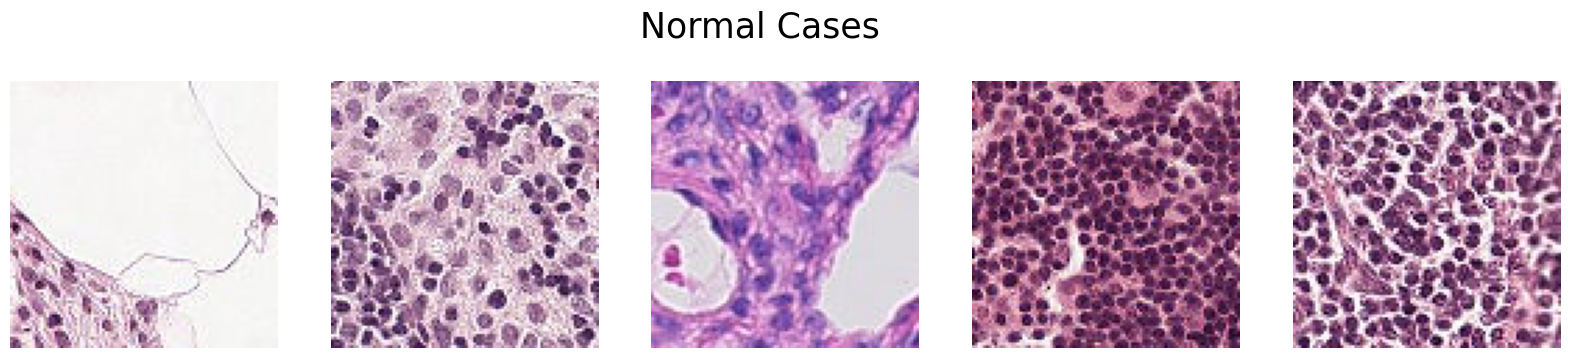

In [19]:
display_images(normal[:5], 'Normal Cases')

#### Analysis

Based on our investigations, we can conclude that:

###### The dataset is balanced with about 40% malignant cases and 60% normal cases
###### All training labels are either 0 (normal) or 1 (malignant)
###### There are no duplicates neither in the training nor testing set
###### Both the test and training images are of the shape 96 x 96 x 3

This implies that there are good reasons to believe that the data should be suitable for an analysis using Convolutional Neural Network.

In [20]:
def generate_data(df, frac=1.0, test_size=0.2):
    if frac == 1.0:
        df_subset = df.copy()
    else: 
        df_subset = df.sample(frac=frac, replace=False) # Sample the data
    df_subset['label'] = df_subset['label'].astype(str)  # Convert labels to strings
    df_subset['id'] = df_subset['id'].apply(lambda x: f'{x}.tif') # Add the '.tif' extension to the 'id' column
    df_train, df_val = train_test_split(df_subset, test_size=test_size) # Split into training and validation sets

    return df_train, df_val


def create_train_generator(df_train):
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory='train',
        x_col='id',
        y_col='label',
        target_size=(96, 96),
        batch_size=32,
        class_mode='binary'
    )
    return train_generator


def create_val_generator(df_val):
    val_datagen = ImageDataGenerator(rescale=1./255)
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=df_val,
        directory='train',  # Update this if your validation data is in a different directory
        x_col='id',
        y_col='label',
        target_size=(96, 96),
        batch_size=32,
        class_mode='binary'
    )
    return val_generator


def create_early_stopper(monitor='val_accuracy', patience=5):
    early_stopper = EarlyStopping(
        monitor=monitor,
        patience=patience,
        verbose=1,
        restore_best_weights=True
    )
    return early_stopper

In [21]:
def plot_training_history(history):
    # Get number of epochs
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training & validation accuracy values
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-ticks to be the epochs
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-ticks to be the epochs
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    

In [22]:
def get_best_epoch_stats(model_names, histories):
    accuracies = []
    losses = []
    
    for model_name, history in zip(model_names, histories):
        # Get the index of the epoch with the highest validation accuracy
        best_epoch_index = np.argmax(history.history['val_accuracy'])
        
        # Retrieve the accuracy and loss for the best epoch
        best_epoch_accuracy = history.history['val_accuracy'][best_epoch_index]
        best_epoch_loss = history.history['val_loss'][best_epoch_index]
        
        # Append the results to the respective lists
        accuracies.append(best_epoch_accuracy)
        losses.append(best_epoch_loss)
    
    return model_names, accuracies, losses 

In [23]:
def plot_model_metrics(architectures, accuracies, losses):
    # Define colors
    accuracy_color = '#5BC0BE'
    loss_color = '#4C698D'

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Plot accuracy
    axs[0].bar(architectures, accuracies, color=accuracy_color)
    axs[0].set_title('Model Accuracy', fontsize=14)
    axs[0].set_ylabel('Accuracy', fontsize=12)
    axs[0].set_ylim([0, 1])

    # Adding the text labels on the bars
    for i in range(len(accuracies)):
        axs[0].text(i, accuracies[i] + 0.02, f'{accuracies[i]:.2f}', ha='center', va='bottom', color='black')

    # Plot loss
    axs[1].bar(architectures, losses, color=loss_color)
    axs[1].set_title('Model Loss', fontsize=14)
    axs[1].set_ylabel('Loss', fontsize=12)
    axs[1].set_ylim([0, max(losses)+0.1])

    # Adding the text labels on the bars
    for i in range(len(losses)):
        axs[1].text(i, losses[i] + 0.02, f'{losses[i]:.2f}', ha='center', va='bottom', color='white')  # white text for better visibility on dark color

    # Layout adjustments
    plt.tight_layout()

    # Display the plot
    plt.show()


In [24]:
# Create training and validation data
df_train, df_val = generate_data(df, frac=1.0, test_size=0.2)

# Create train and validation generator
train_generator  = create_train_generator(df_train)
val_generator    = create_val_generator(df_val)

# early_stopper
early_stopper    = create_early_stopper(monitor='val_accuracy', patience=5)

# CNN Model Structure with Input layer
model_basic = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_basic.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_basic = model_basic.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 5441s 989ms/step - accuracy: 0.7919 - loss: 0.4700 - val_accuracy: 0.8260 - val_loss: 0.4125
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 378s 69ms/step - accuracy: 0.8396 - loss: 0.3848 - val_accuracy: 0.8594 - val_loss: 0.3429
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 351s 64ms/step - accuracy: 0.8520 - loss: 0.3539 - val_accuracy: 0.8520 - val_loss: 0.3459
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 338s 61ms/step - accuracy: 0.8607 - loss: 0.3350 - val_accuracy: 0.8647 - val_loss: 0.3248
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 345s 60ms/step - accuracy: 0.8660 - loss: 0.3236 - val_accuracy: 0.8630 - val_loss: 0.3183
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 273s 50ms/step - accuracy: 0.8697 - loss: 0.3133 - val_accuracy: 0.8695 - val_loss: 0.3022
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 270s 49ms/step - accuracy: 0.8728

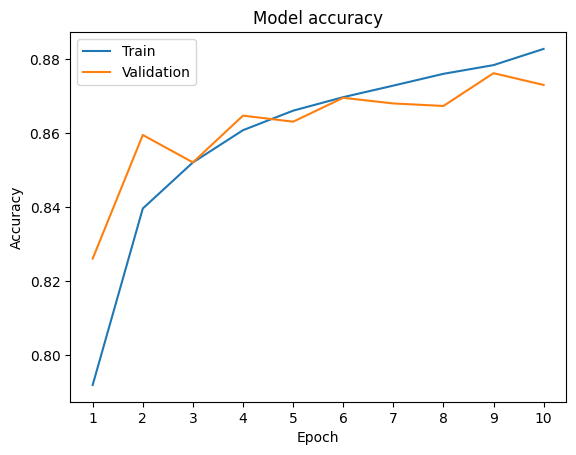

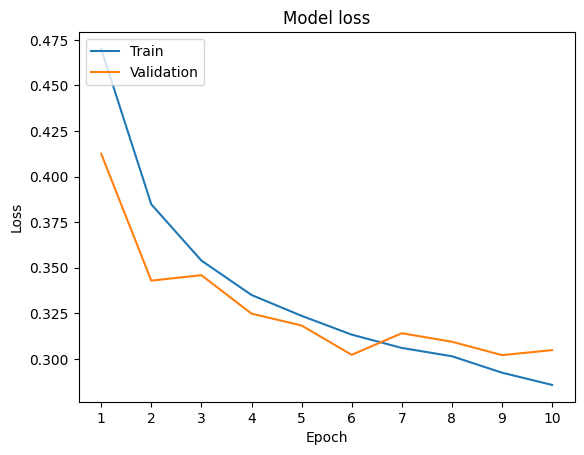

In [25]:
plot_training_history(history_basic)

In [27]:
# Create training and validation data
df_train, df_val = generate_data(df, frac=1.0, test_size=0.2)

# Create train and validation generator
train_generator  = create_train_generator(df_train)
val_generator    = create_val_generator(df_val)

# early_stopper
early_stopper    = create_early_stopper(monitor='val_accuracy', patience=5)

# CNN Model Structure with Input layer and additional Conv and MaxPooling layers
model_deep = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),  # Additional Conv layer
    MaxPooling2D(2, 2),                      # Additional MaxPooling layer
    Flatten(),
    Dense(128, activation='relu'),  # Increased neurons in the Dense layer
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_deep.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_deep = model_deep.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 213s 39ms/step - accuracy: 0.8142 - loss: 0.4219 - val_accuracy: 0.8565 - val_loss: 0.3319
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 254s 46ms/step - accuracy: 0.8659 - loss: 0.3249 - val_accuracy: 0.8742 - val_loss: 0.3003
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 314s 57ms/step - accuracy: 0.8838 - loss: 0.2840 - val_accuracy: 0.8871 - val_loss: 0.2696
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 310s 56ms/step - accuracy: 0.8973 - loss: 0.2577 - val_accuracy: 0.8991 - val_loss: 0.2457
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 346s 63ms/step - accuracy: 0.9057 - loss: 0.2361 - val_accuracy: 0.9096 - val_loss: 0.2268
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 234s 43ms/step - accuracy: 0.9137 - loss: 0.2195 - val_accuracy: 0.9090 - val_loss: 0.2297
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 193s 35ms/step - accuracy: 0.9182 -

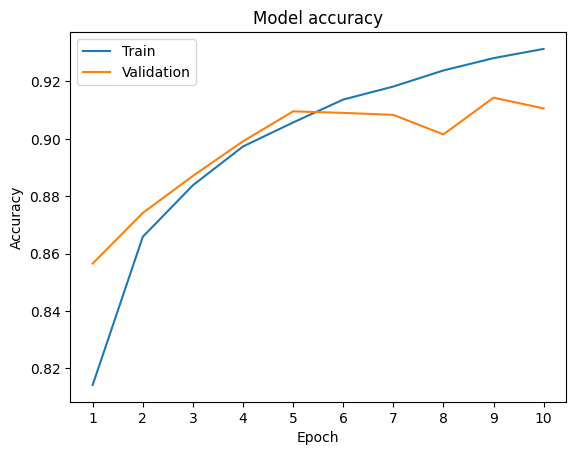

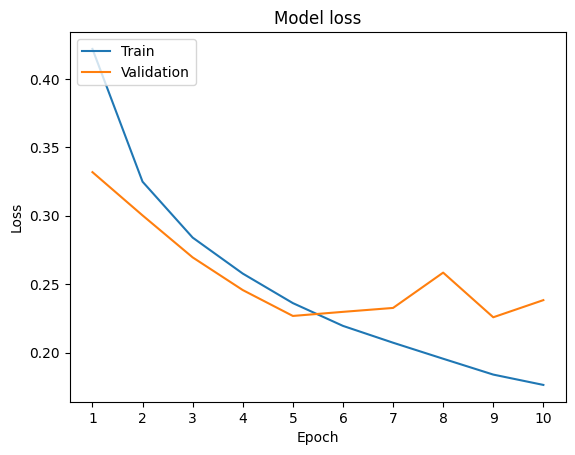

In [28]:
plot_training_history(history_deep)

In [29]:
# Create training and validation data
df_train, df_val = generate_data(df, frac=1.0, test_size=0.2)

# Create train and validation generator
train_generator  = create_train_generator(df_train)
val_generator    = create_val_generator(df_val)

# early_stopper
early_stopper    = create_early_stopper(monitor='val_accuracy', patience=5)

# CNN Model Structure with double convolution layers
model_doubleConv = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile and train the model as before
model_doubleConv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history_doubleConv= model_doubleConv.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 357s 65ms/step - accuracy: 0.8117 - loss: 0.4237 - val_accuracy: 0.8520 - val_loss: 0.3384
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 425s 77ms/step - accuracy: 0.8658 - loss: 0.3242 - val_accuracy: 0.8800 - val_loss: 0.2889
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 442s 80ms/step - accuracy: 0.8871 - loss: 0.2816 - val_accuracy: 0.8961 - val_loss: 0.2538
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 416s 76ms/step - accuracy: 0.8985 - loss: 0.2558 - val_accuracy: 0.8989 - val_loss: 0.2507
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 469s 85ms/step - accuracy: 0.9062 - loss: 0.2356 - val_accuracy: 0.9063 - val_loss: 0.2374
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 495s 90ms/step - accuracy: 0.9143 - loss: 0.2191 - val_accuracy: 0.9063 - val_loss: 0.2314
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 465s 84ms/step - accuracy: 0.9204 -

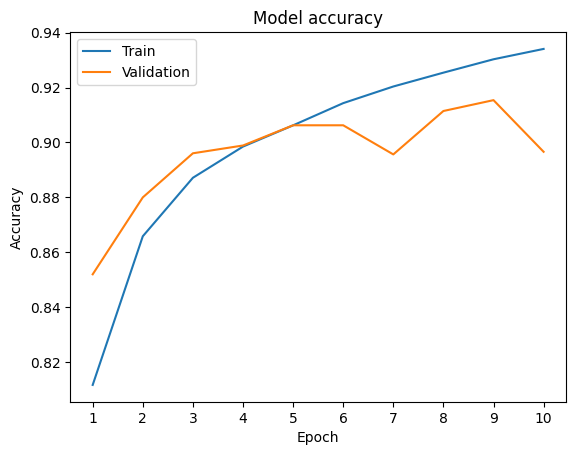

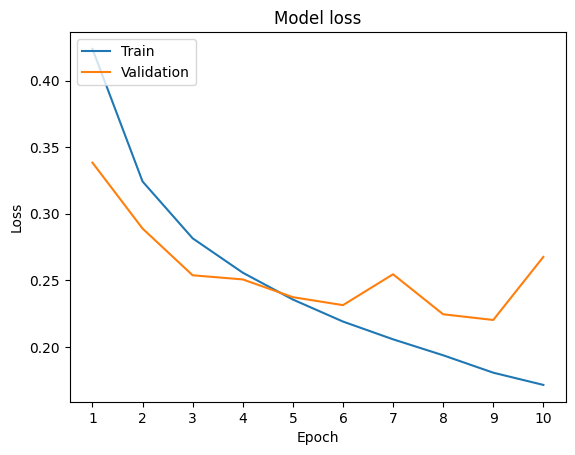

In [30]:
plot_training_history(history_doubleConv)

In [31]:
# Create training and validation data
df_train, df_val = generate_data(df, frac=1.0, test_size=0.2)

# Create train and validation generator
train_generator  = create_train_generator(df_train)
val_generator    = create_val_generator(df_val)

# early_stopper
early_stopper    = create_early_stopper(monitor='val_accuracy', patience=5)

# CNN Model Structure with double convolution layers
model_doubleDeep = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),  # Additional Conv layer
    Conv2D(128, (3, 3), activation='relu'),  # Additional Conv layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile and train the model as before
model_doubleDeep.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history_doubleDeep = model_doubleDeep.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 273s 50ms/step - accuracy: 0.6063 - loss: 0.6125 - val_accuracy: 0.6005 - val_loss: 0.6264
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 296s 54ms/step - accuracy: 0.6847 - loss: 0.5555 - val_accuracy: 0.8100 - val_loss: 0.4291
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 285s 52ms/step - accuracy: 0.8379 - loss: 0.3862 - val_accuracy: 0.8679 - val_loss: 0.3174
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 239s 43ms/step - accuracy: 0.8678 - loss: 0.3200 - val_accuracy: 0.8888 - val_loss: 0.2729
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 470s 85ms/step - accuracy: 0.8836 - loss: 0.2897 - val_accuracy: 0.8934 - val_loss: 0.2577
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 574s 104ms/step - accuracy: 0.8948 - loss: 0.2661 - val_accuracy: 0.8807 - val_loss: 0.2701
Epoch 7/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 535s 97ms/step - accuracy: 0.9024 

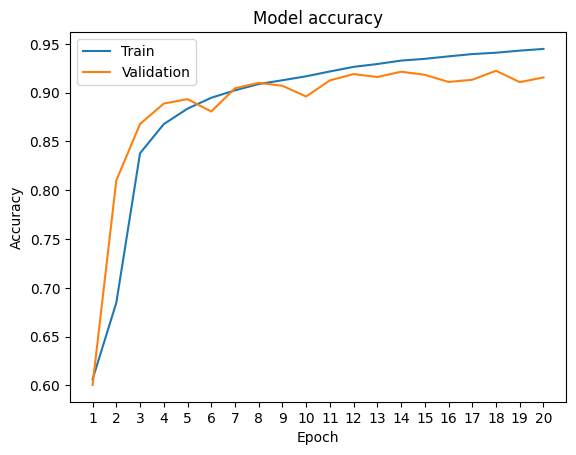

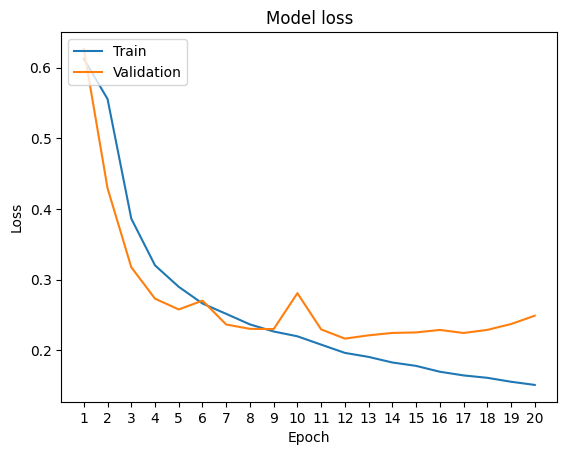

In [32]:
plot_training_history(history_doubleDeep)

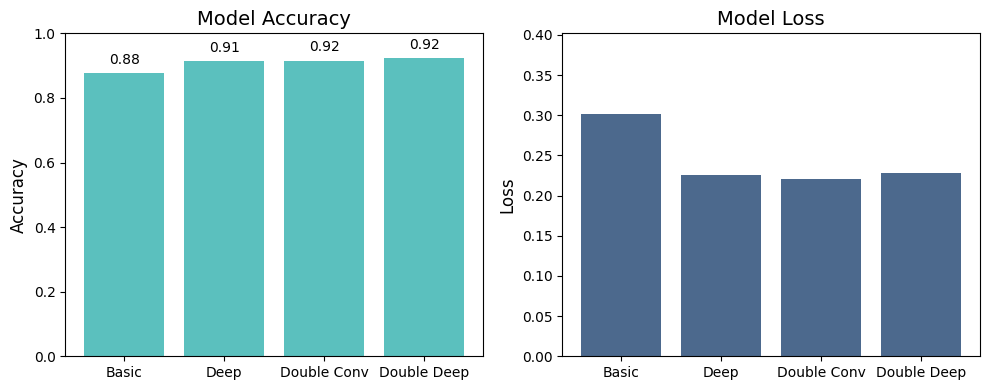

In [33]:
best = get_best_epoch_stats( ('Basic','Deep', 'Double Conv', 'Double Deep'), (history_basic, history_deep, history_doubleConv, history_doubleDeep)  )
plot_model_metrics(*best)

In [34]:
def preprocess_image(image_path):
    """Load an image and preprocess it for the model."""
    img = load_img(image_path, target_size=(96, 96))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image
    return img_array

def predict_batch(images, model):
    """Predict the labels for a batch of images using the trained model."""
    processed_imgs = np.array([preprocess_image('test/' + img_path + '.tif') for img_path in images])
    predictions = model.predict(processed_imgs)
    predicted_classes = [1 if pred[0] > 0.5 else 0 for pred in predictions]
    return predicted_classes

def process_in_batches(df, batch_size, model):
    """Process the dataframe in batches."""
    num_batches = len(df) // batch_size + (0 if len(df) % batch_size == 0 else 1)
    results = []

    for i in range(num_batches):
        batch = df['id'][i*batch_size:(i+1)*batch_size]
        batch_results = predict_batch(batch, model)
        results.extend(batch_results)
    
    return results

In [35]:
# Create training and validation data
df_train, df_val = generate_data(df, frac=1.0, test_size=0.2)

# Create train and validation generator
train_generator  = create_train_generator(df_train)
val_generator    = create_val_generator(df_val)

# early_stopper
early_stopper    = create_early_stopper(monitor='val_accuracy', patience=5)

model_doubleDeep_RMSprop= Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),  # Additional Conv layer
    Conv2D(128, (3, 3), activation='relu'),  # Additional Conv layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile and train the model as before
model_doubleDeep_RMSprop.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history_doubleDeep_RMSprop = model_doubleDeep_RMSprop.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 762s 138ms/step - accuracy: 0.8059 - loss: 0.4374 - val_accuracy: 0.8743 - val_loss: 0.3029
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 524s 95ms/step - accuracy: 0.8664 - loss: 0.3335 - val_accuracy: 0.8549 - val_loss: 0.3241
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 455s 83ms/step - accuracy: 0.8839 - loss: 0.3007 - val_accuracy: 0.8923 - val_loss: 0.2800
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 372s 68ms/step - accuracy: 0.8827 - loss: 0.3139 - val_accuracy: 0.8986 - val_loss: 0.2928
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 300s 55ms/step - accuracy: 0.8653 - loss: 0.3595 - val_accuracy: 0.8920 - val_loss: 0.2819
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 353s 64ms/step - accuracy: 0.8228 - loss: 0.4589 - val_accuracy: 0.7258 - val_loss: 0.4641
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 397s 72ms/step - accuracy: 0.7738 

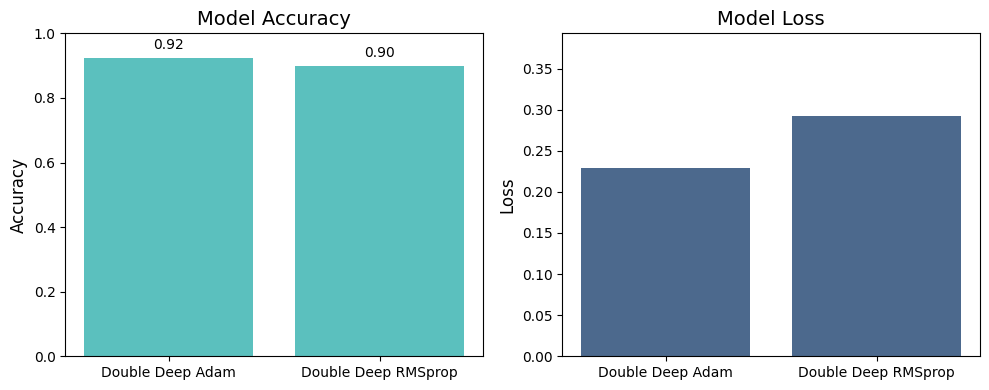

In [36]:
best = get_best_epoch_stats( ('Double Deep Adam', 'Double Deep RMSprop'), (history_doubleDeep, history_doubleDeep_RMSprop)  )
plot_model_metrics(*best)

In [37]:
# Create training and validation data
df_train, df_val = generate_data(df, frac=1.0, test_size=0.2)

# Create train and validation generator
train_generator  = create_train_generator(df_train)
val_generator    = create_val_generator(df_val)

# early_stopper
early_stopper    = create_early_stopper(monitor='val_accuracy', patience=5)

# Define L2 regularization factor
l2_factor = 0.001  # This value can be adjusted based on your nee

# CNN Model Structure with Input layer and additional Conv and MaxPooling layers
model_l2_001 = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),# Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),# Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),# Additional Conv layer
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),# Additional Conv layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(l2_factor)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile and train the model as before
model_l2_001.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history_l2_001 = model_l2_001.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 394s 71ms/step - accuracy: 0.7561 - loss: 0.5388 - val_accuracy: 0.8088 - val_loss: 0.4523
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 595s 108ms/step - accuracy: 0.8162 - loss: 0.4564 - val_accuracy: 0.8272 - val_loss: 0.4083
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 427s 78ms/step - accuracy: 0.8247 - loss: 0.4399 - val_accuracy: 0.8255 - val_loss: 0.4087
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 416s 76ms/step - accuracy: 0.8292 - loss: 0.4296 - val_accuracy: 0.8395 - val_loss: 0.3879
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 447s 81ms/step - accuracy: 0.8294 - loss: 0.4246 - val_accuracy: 0.8393 - val_loss: 0.3864
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 299s 54ms/step - accuracy: 0.8312 - loss: 0.4203 - val_accuracy: 0.8408 - val_loss: 0.3860
Epoch 7/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 332s 60ms/step - accuracy: 0.8322 

In [38]:
# Create training and validation data
df_train, df_val = generate_data(df, frac=1.0, test_size=0.2)

# Create train and validation generator
train_generator  = create_train_generator(df_train)
val_generator    = create_val_generator(df_val)

# early_stopper
early_stopper    = create_early_stopper(monitor='val_accuracy', patience=5)

# Define L2 regularization factor
l2_factor = 0.0001  # This value can be adjusted based on your nee

# CNN Model Structure with Input layer and additional Conv and MaxPooling layers
model_l2_0001 = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),# Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),# Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),# Additional Conv layer
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2_factor)),# Additional Conv layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(l2_factor)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile and train the model as before
model_l2_0001.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history_l2_0001 = model_l2_0001.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 501s 91ms/step - accuracy: 0.7977 - loss: 0.4669 - val_accuracy: 0.8088 - val_loss: 0.4261
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 447s 81ms/step - accuracy: 0.8502 - loss: 0.3793 - val_accuracy: 0.8559 - val_loss: 0.3502
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 515s 94ms/step - accuracy: 0.8654 - loss: 0.3540 - val_accuracy: 0.8800 - val_loss: 0.2994
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 721s 131ms/step - accuracy: 0.8775 - loss: 0.3311 - val_accuracy: 0.8890 - val_loss: 0.2819
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 482s 88ms/step - accuracy: 0.8870 - loss: 0.3161 - val_accuracy: 0.8654 - val_loss: 0.3186
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 720s 131ms/step - accuracy: 0.8913 - loss: 0.3056 - val_accuracy: 0.8980 - val_loss: 0.2680
Epoch 7/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 604s 110ms/step - accuracy: 0.897

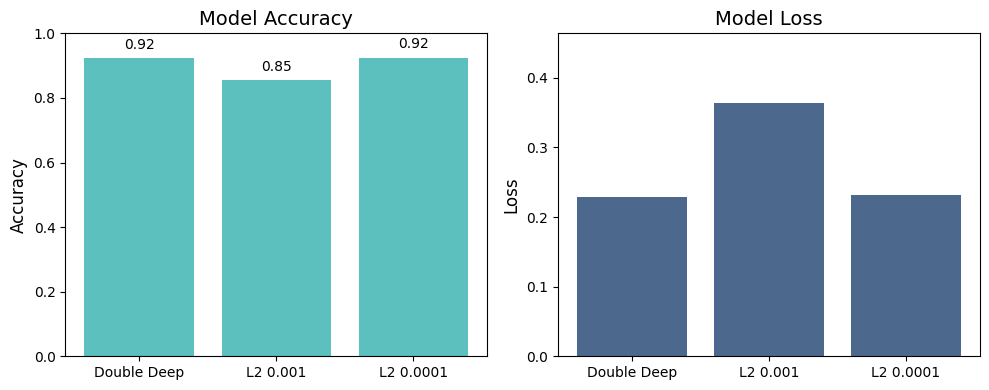

In [39]:
best = get_best_epoch_stats( ('Double Deep', 'L2 0.001', 'L2 0.0001'), (history_doubleDeep, history_l2_001, history_l2_0001)  )
plot_model_metrics(*best)

In [42]:
model_doubleDeep_RMSprop.save('models/model_doubleDeep_RMSprop.keras')
model_l2_001.save('models/model_l2_001.keras')
model_l2_0001.save('models/model_l2_0001.keras')

# Save history
with open('history/model_doubleDeep_RMSprop.pkl', 'wb') as file:
    pickle.dump(history_doubleDeep_RMSprop.history, file)

with open('history/model_l2_001.pkl', 'wb') as file:
    pickle.dump(history_l2_001.history, file)

with open('history/model_l2_0001.pkl', 'wb') as file:
    pickle.dump(history_l2_0001.history, file)

In [43]:
df_sample = pd.read_csv("sample_submission.csv")
df_sample

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
...,...,...
57453,061847314ded6f81e1cd670748bfa2003442c9c7,0
57454,6f3977130212641fd5808210015a609c658dcbff,0
57455,46935f247278539eca74b54d07d666efb528a753,0
57456,a09bcae08a82120183352e0e869181b2911d3dc1,0


In [44]:
start = time.perf_counter()
batch_size = 100 
df_sample['label'] = process_in_batches(df_sample, batch_size, model_doubleDeep)
end = time.perf_counter()
print(end - start)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━

In [45]:
df_sample.to_csv('kaggle.csv', index=False)

In this assignment, we demonstrated that convolutional neural networks can reliably distinguish metastatic from normal tissue in histopathologic lymph-node scans. Our top-performing model achieved a validation accuracy of % (please insert your value). We also observed:

    Model architecture matters most. Architectural choices had a larger impact on performance than conventional hyperparameter tuning or regularization.

    Depth and paired convolutions boost accuracy. Increasing depth and using double-convolution blocks both improved results, and combining them yielded the strongest performance.

    Experimentation is costly. Exploring many architectures and hyperparameter configurations is challenging because each CNN takes so long to train.